In [1]:
%matplotlib inline

In [2]:
from KnackpackData import getEncoded,getScores,scoreFunction
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        chromosome[:int(0.8*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

In [4]:
def fitness_score(population):
    scores = np.array(list(map(scoreFunction, population)))
    population = np.array(population)
    order = np.argsort(-scores)
    return scores

In [5]:
def selection(scores,pop_after_fit,n_parents):
    return np.array(random.choices(pop_after_fit, weights = scores, k = n_parents))

In [6]:
def crossover(pop_after_sel,target_population_size=4):
    def crossingMethod(index,modifier):
        point = random.randint(0, len(pop_after_sel[0]))
        next_index = (index+modifier)%len(pop_after_sel)
        return np.concatenate((pop_after_sel[index][:point],pop_after_sel[next_index][point:]))
    childrens = np.array([crossingMethod(index,modifier) for modifier in range(target_population_size) for index in range(len(pop_after_sel))])
    return np.concatenate((pop_after_sel,childrens))

In [7]:
def mutation(pop_after_cross,mutation_rate):
    mutated_data = np.array([[ (random.random() < mutation_rate) != x for x in chromosome] for chromosome in pop_after_cross])
    return np.concatenate((pop_after_cross,mutated_data))

## Add max iterations, crossover rate

In [23]:
def generations(size,n_feat,n_parents,mutation_rate,n_gen):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores = fitness_score(population_nextgen)
        bestIndex = np.argmax(scores)
        best_chromo.append(population_nextgen[bestIndex])
        best_score.append(scores[bestIndex])
        pop_after_sel = selection(scores,population_nextgen,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
  
    return best_chromo,best_score

In [24]:
from operator import itemgetter
def plotScore(scores,bestindex):
    plt.figure(figsize=(8, 6), dpi=80) 
    plt.plot(scores)
    plt.scatter(bestindex, scores[bestindex],color="g",s=50)
    plt.annotate("best", (bestindex,scores[bestindex]))
    plt.ylabel('scores')
    plt.show()
    
def getBest(chromosomes,scores):
    best = max(zip(chromosomes,scores), key=itemgetter(1))
    bestindex = scores.index(best[1])
    return best,bestindex

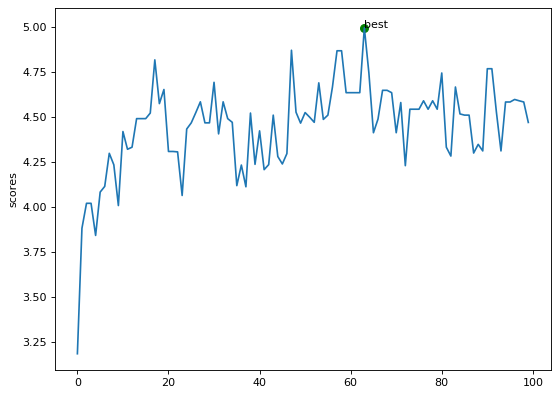

Final value[ True  True  True  True  True False False False False  True  True False
  True False False  True]=4.996682643890381


In [25]:
np.random.seed(seed=1337)
random.seed(1337)
chromo,score=generations(size=100,n_feat=16,n_parents=20,mutation_rate=0.2,
                     n_gen=100)
best,bestindex = getBest(chromo,score)
plotScore(score,bestindex)
x = best[0]
y = scoreFunction(best[0])
print(f"Final value{x}={y}")